In [1]:
import numpy as np
import random

import pollution

import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange
import tqdm
import os
import imageio.v2 as imageio
import math
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import networkx as nx
import os
import math
import matplotlib.ticker as mtick
import ipywidgets as widgets
from scipy.optimize import minimize_scalar, minimize
from matplotlib.lines import Line2D

font = {        'size'   : 20}
mpl.rc('font', **font)
params = {'figure.figsize': (10, 5),
          'font.family':'sans-serif',
          'font.sans-serif':'Nimbus Sans'}#,
#           'font.family':'sans-serif',
#           'font.sans-serif':'HelveticaNeueMedium'}
matplotlib.rcParams.update(params)
# matplotlib.rcParams['font.family'] = "sans-serif"
# matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"
# %matplotlib notebook

In [ ]:
T = 200
N = 50
D = 3*N//5
L = 50
mu=0.5

pcp = np.zeros(T+1)
pce = np.zeros(T+1)

world = pollution.World(L=L,N=N,D=D,phi=5,R=5,M_nu=0,epsilon=0,mu=mu)
with imageio.get_writer(f'Animation/fixed_strat_p1.gif', mode='I') as writer:
    for i in trange(T+1):
        fig,ax=plt.subplots(figsize=(6,6))
        ax.imshow(world.pollution_grid,cmap='bwr',vmin=-3,vmax=3) 
        pcp[i] = world.per_capita_pollution()
        pce[i] = world.per_capita_expense()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        fig.savefig(f'Animation/{i}.png',bbox_inches='tight')
        plt.close()
        world.step()
        image = imageio.imread(f'Animation/{i}.png')
        writer.append_data(image)
        os.remove(f'Animation/{i}.png')

In [ ]:
plt.plot(range(T+1),pcp)
plt.plot(range(T+1),pce)

In [51]:
T=200
N=50
D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu=[0.001,0.01]
pcp = np.zeros((len(D),len(mu),runs))
# world = pollution.World(L=L,N=N,D=D[2],phi=5,R=5,M_nu=0,mu=mu[2])

for i in range(len(D)):
    for j in trange(len(mu)):
        for k in range(runs):
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu[j])
            pcp[i,j,k] -= world.per_capita_pollution()
            for t in range(T):
                world.step()
            pcp[i,j,k] += world.per_capita_pollution()
np.savetxt('Data/Fixed Strategy/e.csv',pcp.reshape(len(D)*len(mu),runs))

100%|█████████████████████████████████████████████| 2/2 [02:51<00:00, 85.55s/it]


# Combining fixed strat data

In [52]:
a = np.loadtxt('Data/Fixed Strategy/a.csv').reshape(len(D),10,10)
b = np.loadtxt('Data/Fixed Strategy/b.csv').reshape(len(D),10,20)
c = np.loadtxt('Data/Fixed Strategy/c.csv').reshape(len(D),10,20)
d = np.loadtxt('Data/Fixed Strategy/d.csv').reshape(len(D),4,50)
e = np.loadtxt('Data/Fixed Strategy/e.csv').reshape(len(D),2,50)
pcp = np.concatenate([e,d,np.concatenate([a,b,c],axis=-1)],axis=1)
print(pcp.shape)

(4, 16, 50)


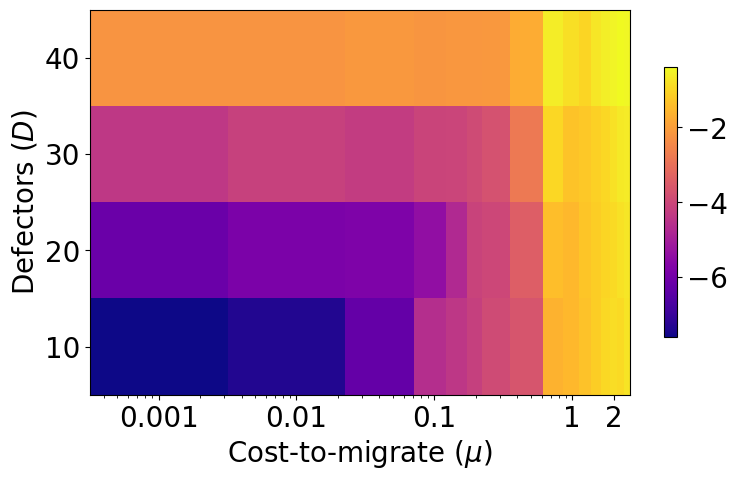

In [67]:
scale='log'
D_corners = [5,15,25,35,45]
if scale=='log':
    mu = [1e-4,1e-3,1e-2] + list(np.arange(0.05,0.225,0.05)) + list(np.arange(0.25,2.8,0.25)) 
    mu_corners = [np.sqrt(mu[i]*mu[i+1]) for i in range(len(mu)-1)]
else:
#     mu_corners = [0.025,0.075,0.125,0.175,0.225,0.375,0.625,0.875,1.125,1.375,1.625,1.875,2.125,2.375,2.625]
    mu = [0,1e-3,1e-2] + list(np.arange(0.05,0.225,0.05)) + list(np.arange(0.25,2.8,0.25))
    mu_corners = np.diff(mu)/2 + mu[:-1]
    
mu_mesh,D_mesh = np.meshgrid(mu_corners,D_corners)

fig,ax = plt.subplots(figsize=(10,5))
# im=ax.imshow(pcp.mean(axis=-1),cmap='plasma',origin='lower')
im=ax.pcolormesh(mu_mesh,D_mesh,pcp.mean(axis=-1),cmap='plasma')
# ax.set_yticks([0,1,2,3])
# ax.set_yticklabels(D)
# ax.set_xticks(np.arange(0,len(mu),1))
# ax.set_xticklabels(mu[0::1])
ax.set_xscale(scale)
if scale=='log':
    ax.set_xticks([0.001,0.01,0.1,1,2])
    ax.set_xticklabels([0.001,0.01,0.1,1,2])

ax.set_ylabel("Defectors ($D$)")
ax.set_xlabel("Cost-to-migrate ($\mu$)")
# plt.subplots_adjust(wspace=0.1)#,hspace=0.1,bottom=0.25)
fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
fig.colorbar(im,shrink=0.7)
fig.savefig("Figures/Fixed Strategy all+de log.png",bbox_inches='tight')

# Clusters

In [10]:
T=200
N=50
D=[10,20,30,40]
R=5
phi=5
L = 50
runs=50
mu=np.arange(0.25,2.6,0.25)
cc = np.zeros((len(D),len(mu),2,runs))
# world = pollution.World(L=L,N=N,D=D[2],phi=5,R=5,M_nu=0,mu=mu[2])

for k in trange(runs):
    for i in range(len(D)):
        for j in range(len(mu)):
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu[j])
            for t in range(T):
                world.step()
            ccs = world.observe_clusters()
            if len(ccs)>0:
                cc[i,j,:,k] = [len(ccs),sum([len(c) for c in ccs])/len(ccs)]
np.savetxt('Data/Fixed Strategy/CC.csv',cc.reshape(len(D)*len(mu)*2,runs))

100%|███████████████████████████████████████████| 50/50 [51:31<00:00, 61.84s/it]


/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


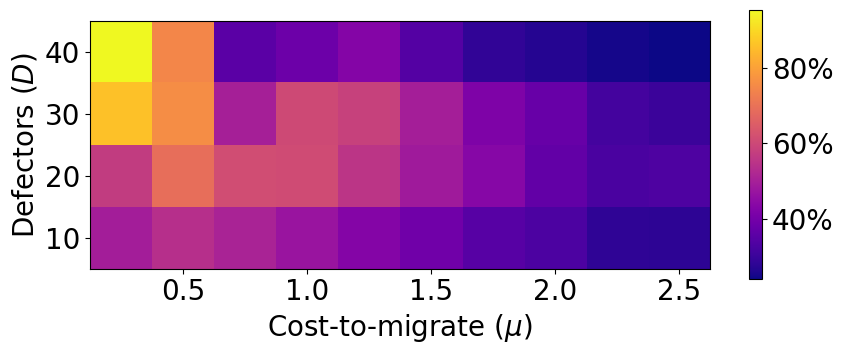

In [18]:
fig,ax = plt.subplots(figsize=(10,5))
im=ax.imshow((cc[:,:,0,:]*cc[:,:,1,:]).mean(axis=-1)/N,cmap='plasma',origin='lower')
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(D)
ax.set_xticks(np.arange(1,len(mu),2))
ax.set_xticklabels(mu[1::2])

ax.set_ylabel("Defectors ($D$)")
ax.set_xlabel("Cost-to-migrate ($\mu$)")
# plt.subplots_adjust(wspace=0.1)#,hspace=0.1,bottom=0.25)
# fig.subplots_adjust(right=0.8)
cbar=fig.colorbar(im,shrink=0.7)
vals = cbar.get_ticks()
cbar.set_ticklabels(['{:,.0%}'.format(x) for x in vals])
fig.savefig("Figures/Fixed Strategy CC.png",bbox_inches='tight')

In [9]:
world.observe_clusters()

[{4, 16, 36}, {37, 41, 45}, {1, 28, 47}, {6, 14, 15}, {3, 27, 44}, {8, 18, 38}]

# Making code more efficient

In [ ]:
T=200
N=50
D=[10,20,30,40]
R=5
phi=5
L = 50
runs=20
mu=np.arange(0.25,2.6,0.25)

In [ ]:
world = pollution.World(L=L,N=N,D=D[2],phi=5,R=5,M_nu=0,mu=mu[2])
a_pos = [a.position for a in world.agents]
print(a_pos)

In [ ]:
%timeit world.pollute()

In [ ]:
%timeit world.pollute1()

In [ ]:
%timeit world.calc_expense()

In [ ]:
%timeit world.calc_expense1()

In [ ]:
neighbours = [len([world.return_agent(world.lattice_sites[pt])[0] for pt in
                                pollution.points_within_range(a.position,
                                            1,
                                            world.size)
                                if world.lattice_sites[pt]>0]) for a in world.agents]

print(neighbours)

In [ ]:
agent = world.agents[23]
print(agent.position)
world.lattice_sites[world.agents[0].position] = 0
world.agents[0].position = (19,19)
world.lattice_sites[world.agents[0].position] = world.agents[0].label
neighbours = [world.return_agent(world.lattice_sites[pt])[0] for pt in
                                pollution.points_within_range(agent.position,1,world.size)
                                if world.lattice_sites[pt]>0]
world.pollute()
world.calc_expense()
print(neighbours)

In [ ]:
def min_neighbour(agent,world):
    neighbour_expense = {a.label:a.expense for a in neighbours}
    best_neighbour = np.random.choice([k for k, v in neighbour_expense.items() if v==min(neighbour_expense.values())])
    return world.return_agent(best_neighbour)[0].type
    
def min_neighbour1(agent,world):
    neighbour_expense = np.array([a.expense for a in neighbours])
    neighbour_label = np.array([a.label for a in neighbours])
    best_neighbour = np.random.choice(neighbour_label[neighbour_expense==neighbour_expense.min()])
    return world.return_agent(best_neighbour)[0].type
    
def min_neighbour2(agent,world):
    neighbour_expense = {a:a.expense for a in neighbours}
    return np.random.choice([k for k, v in neighbour_expense.items() if v==min(neighbour_expense.values())]).type

def ret_neighs(agent,world):
    return [world.return_agent(world.lattice_sites[pt])[0] for pt in
                                pollution.points_within_range(agent.position,1,world.size)
                                if world.lattice_sites[pt]>0]

def ret_neighs1(agent,world):
    return [a for a in world.agents 
            if pollution.torus_distance(np.array(a.position),
                                        np.array(agent.position),world.size)<=1]

# Uniting the above frameworks

In [3]:
T=50
N=50
D=[N//5,2*N//5,3*N//5,4*N//5]
R=5
phi=5
L = 50
runs=50
mu=np.arange(0,0.31,0.01)
pcp = np.zeros((len(D),len(mu),runs))
cc = np.zeros((len(D),len(mu),runs))
# world = pollution.World(L=L,N=N,D=D[2],phi=5,R=5,M_nu=0,mu=mu[2])

for k in trange(runs):
    for j in range(len(mu)):
        for i in range(len(D)):
            world = pollution.World(L=L,N=N,D=D[i],phi=5,R=5,M_nu=0,mu=mu[j])
            pcp[i,j,k] -= world.per_capita_pollution()
            for t in range(T):
                world.step()
            pcp[i,j,k] += world.per_capita_pollution()
            clusters = world.observe_clusters()
            if len(clusters)>0:
                for c in range(len(clusters)):
                    clusters[0].update(clusters[c])
                cc[i,j,k] = len(clusters[0])/len(world.agents)
np.savetxt(f'Data/Fixed Strategy/N{N}pcp_fin_zoom.csv',pcp.reshape(len(D)*len(mu),runs))
np.savetxt(f'Data/Fixed Strategy/N{N}cc_fin_zoom.csv',cc.reshape(len(D)*len(mu),runs))

100%|███████████████████████████████████████████| 50/50 [41:33<00:00, 49.86s/it]


# Figures

In [2]:
T=50
N=50
D=[N//5,2*N//5,3*N//5,4*N//5]
R=5
phi=5
L = 50
runs=50
mu=np.arange(0,1.05,0.05)
if N==50:
    pcp=np.loadtxt('Data/Fixed Strategy/pcp_fin.csv').reshape(len(D),len(mu),runs)
    cc=np.loadtxt('Data/Fixed Strategy/cc_fin.csv').reshape(len(D),len(mu),runs)
else:
    pcp=np.loadtxt(f'Data/Fixed Strategy/N{N}pcp_fin.csv').reshape(len(D),len(mu),runs)
    cc=np.loadtxt(f'Data/Fixed Strategy/N{N}cc_fin.csv').reshape(len(D),len(mu),runs)
    
D_corners = [0.1,0.3,0.5,0.7,0.9]
mu_corners = np.diff(np.array([-0.05]+list(mu)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_mesh,D_mesh = np.meshgrid(mu_corners,D_corners)
R = np.array([[np.corrcoef(cc[i,j,:],pcp[i,j,:])[1,0] for j in range(cc.shape[1])] 
              for i in range(cc.shape[0])])

mu_grid,D_grid=np.meshgrid(mu,D)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: HelveticaNeueMedium


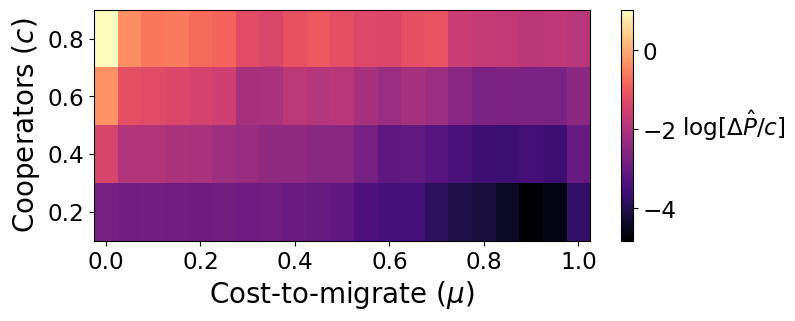

In [7]:
fig,ax = plt.subplots(figsize=(8,3))
# im=ax.imshow(pcp.mean(axis=-1),cmap='plasma',origin='lower')
im=ax.pcolormesh(mu_mesh,1-D_mesh,np.log(pcp.mean(axis=-1)/(1-D_grid)),cmap='magma')#,vmin=-20,vmax=0)

ax.set_ylabel("Cooperators ($c$)")
ax.set_xlabel("Cost-to-migrate ($\mu$)")
cb=fig.colorbar(im)
cb.set_label(label=r'$\log[\Delta \hat{P} / c]$',size='small',rotation=0,va='center',ha='left')
# plt.subplots_adjust(wspace=0.1)#,hspace=0.1,bottom=0.25)
# fig.subplots_adjust(right=0.8)
# # # cbar_ax = fig.add_axes([0.82, 0.15, 0.05, 0.7])
# fig.colorbar(im)
# fig.savefig("Figures/Fixed Strategy/pcp_fin.png",bbox_inches='tight')

Text(0.5, 0, 'Mobility cost, $\\mu$')

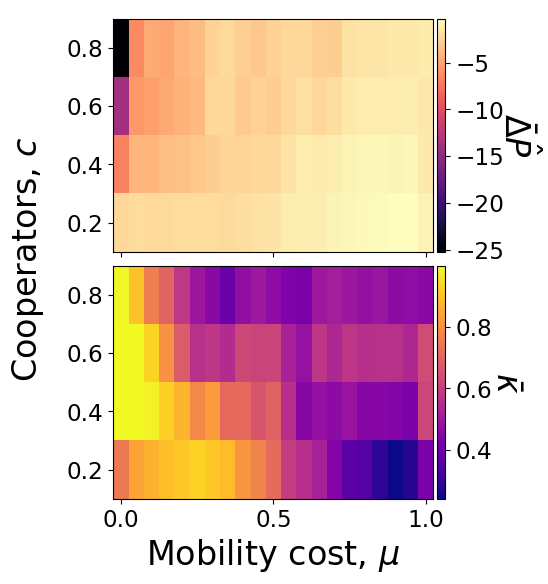

In [12]:
fig,axs = plt.subplots(figsize=(4,6),nrows=2,sharex=True,sharey=True)
c_labels = [r'$\bar{\Delta}\hat{P}$',r'$\bar{\kappa}$',r'$\rho(\Delta\hat{P},\kappa)$']
metrics = [pcp,cc,R.reshape(4,21,1)]
cmaps = ['magma','plasma','PRGn_r']
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.06)
vmins=[m.mean(axis=-1).min() for m in metrics]
vmaxs=[m.mean(axis=-1).max() for m in metrics]
vmins[-1]=-0.9
vmaxs[-1]=0.9
for i in range(2):
    im=axs[i].pcolormesh(mu_mesh,1-D_mesh,metrics[i].mean(axis=-1),
                         cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
    axs[i].set_yticks([0.2,0.4,0.6,0.8])
    pos=axs[i].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.02,pos.ymax-pos.ymin])    
    cb=fig.colorbar(im,cax=cax)
    cb.set_label(label=c_labels[i],size='large',rotation=-90,va='center',ha='center',labelpad=10)

ax_outer=fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel(r"Cooperators, $c$",size='large',labelpad=15)
plt.xlabel("Mobility cost, $\mu$",size='large')
# fig.savefig("Figures/Fixed Strategy/baseline_fin.png",bbox_inches='tight')

In [6]:
print(mu)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3 ]


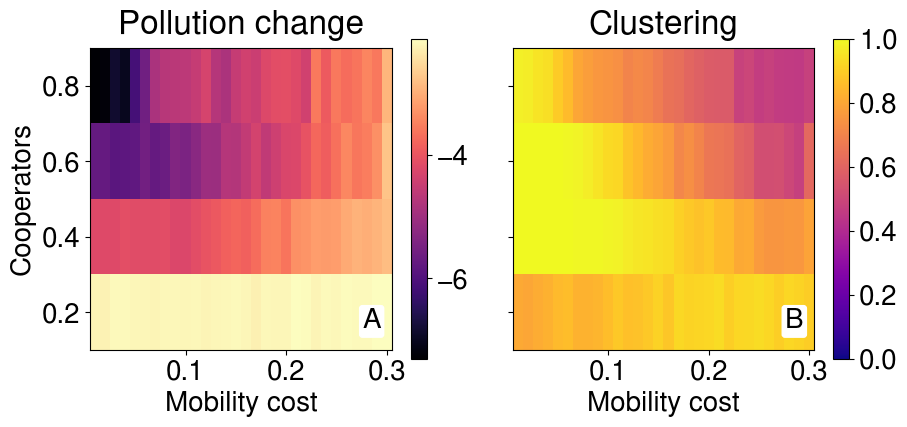

In [8]:
N=50
D=[N//5,2*N//5,3*N//5,4*N//5]
# mu=np.arange(0,1.05,0.05)
mu=np.arange(0,0.31,0.01)
runs=50
pcp=np.loadtxt('Data/Fixed Strategy/N50pcp_fin_zoom.csv').reshape(len(D),len(mu),runs)
cc=np.loadtxt('Data/Fixed Strategy/N50cc_fin_zoom.csv').reshape(len(D),len(mu),runs)
D_corners = [0.1,0.3,0.5,0.7,0.9]
# mu_corners = np.diff(np.array([-0.05]+list(mu)+[1.05]))/2 + np.arange(-0.05,1.05,0.05)
mu_corners = np.diff(np.array([-0.01]+list(mu)+[0.31]))/2 + np.arange(-0.01,0.31,0.01)
mu_mesh,D_mesh = np.meshgrid(mu_corners,D_corners)

fig,axs = plt.subplots(figsize=(10,4),ncols=2,
                       sharex=True,sharey=True,subplot_kw=dict(box_aspect=1))
c_labels = ['Pollution change', 'Clustering']
metrics = [pcp,cc]
cmaps = ['magma','plasma']
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.12,
                    hspace=0.06)
vmins=[m[:,1:,:].mean(axis=-1).min() for m in metrics]
vmaxs=[m[:,1:,:].mean(axis=-1).max() for m in metrics]
# vmaxs[0]=0
vmins[1]=0
vmaxs[1]=1
letters=['A','B']
for i in range(2):
    im=axs[i].pcolormesh(mu_mesh,1-D_mesh,metrics[i].mean(axis=-1),
                         cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i])
    axs[i].set_yticks([0.2,0.4,0.6,0.8])
    axs[i].set_xticks([0,0.1,0.2,0.3])
    axs[i].set_xlim([0.005,0.305])
    axs[i].set_title(c_labels[i],pad=10)
    axs[i].set_xlabel("Mobility cost")
    axs[i].text(0.95*max(mu),0.175,letters[i],va='center',ha='center',
                bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
    cb=fig.colorbar(im,ax=axs[i])

axs[0].set_ylabel("Cooperators") 
# if N==50:
#     fig.savefig("Figures/Fixed Strategy/baseline_fin_alt_zoom.png",bbox_inches='tight')
fig.savefig("Figures/Fixed Strategy/baseline_fin_alt_zoom_no0.eps",bbox_inches='tight',format='eps')
# else:
#     fig.savefig(f"Figures/Fixed Strategy/N{N}baseline_fin_alt.png",bbox_inches='tight')
#     fig.savefig(f"Figures/Fixed Strategy/N{N}baseline_fin_alt.eps",bbox_inches='tight',format='eps')

In [34]:
pcp.min()

-41.798313258636796

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


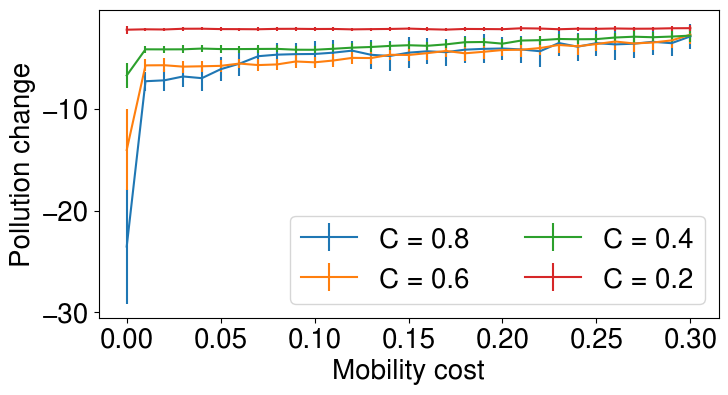

In [35]:
labels=[f'C = {c}' for c in [0.8,0.6,0.4,0.2]]
fig,ax=plt.subplots(figsize=(8,4))
start=1
for i in range(4):
    ax.errorbar(mu[0:],np.mean(pcp[i,0:,:],axis=-1),yerr=pcp[i,0:,:].std(axis=-1),label=labels[i])
#     plt.errorbar(mu[start:],np.median(pcp[i,start:,:],axis=-1),
#                  yerr=[pcp[i,start:,:].max(axis=-1),pcp[i,start:,:].min(axis=-1)],label=labels[i])
ax.set_xlabel('Mobility cost')
ax.set_ylabel('Pollution change')
ax.legend(loc='lower right',ncol=2)
fig.savefig('Figures/Fixed Strategy/baseline_zoom_graph.eps',bbox_inches='tight',format='eps')

In [11]:
print(mu_corners)

[-0.005  0.005  0.015  0.025  0.035  0.045  0.055  0.065  0.075  0.085
  0.095  0.105  0.115  0.125  0.135  0.145  0.155  0.165  0.175  0.185
  0.195  0.205  0.215  0.225  0.235  0.245  0.255  0.265  0.275  0.285
  0.295  0.305]


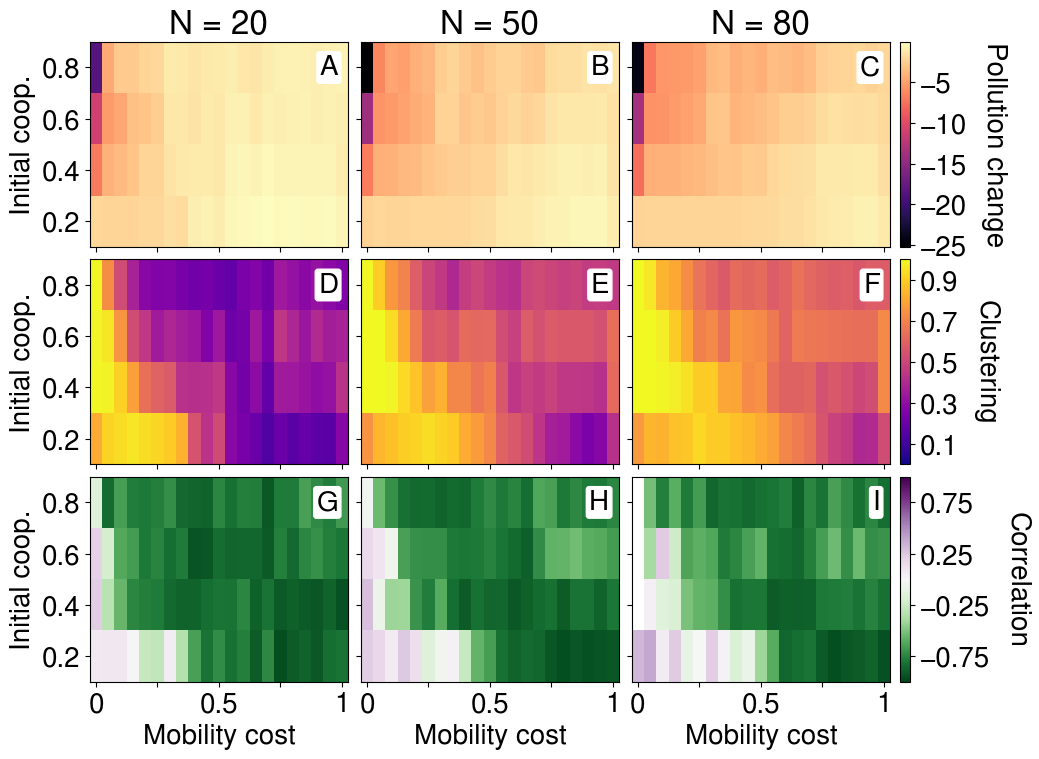

In [30]:
folder = 'Data/Fixed Strategy/'
N = [20,50,80]
pcp= np.stack([np.loadtxt(folder+'N20pcp_fin.csv').reshape(len(D),len(mu),runs),
               np.loadtxt(folder+'pcp_fin.csv').reshape(len(D),len(mu),runs),
               np.loadtxt(folder+'N80pcp_fin.csv').reshape(len(D),len(mu),runs)],
              axis=0)
cc= np.stack([np.loadtxt(folder+'N20cc_fin.csv').reshape(len(D),len(mu),runs),
               np.loadtxt(folder+'cc_fin.csv').reshape(len(D),len(mu),runs),
               np.loadtxt(folder+'N80cc_fin.csv').reshape(len(D),len(mu),runs)],
              axis=0)
R = np.array([[[np.corrcoef(cc[i,j,k,:],pcp[i,j,k,:])[1,0] 
                for k in range(cc.shape[2])] 
               for j in range(cc.shape[1])] 
              for i in range(cc.shape[0])])

fig,axs=plt.subplots(nrows=3,ncols=3,sharex=True,sharey=True,figsize=(10,8))
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.05,
                    hspace=0.06)
cc_lims = [np.min(cc.mean(axis=-1)),np.max(cc.mean(axis=-1))]
pcp_lims = [np.min(pcp.mean(axis=-1)),np.max(pcp.mean(axis=-1))]

ims=[0,0,0]
for i in range(3):
    axs[0,i].set_title(f"N = {N[i]}",size='large')
    ims[0]=axs[0,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(pcp[i],axis=-1),
                        cmap='magma',vmin=pcp_lims[0],vmax=pcp_lims[1])
    ims[1]=axs[1,i].pcolormesh(mu_mesh,1-D_mesh,np.mean(cc[i],axis=-1),vmin=0,vmax=1,cmap='plasma')
    ims[2]=axs[2,i].pcolormesh(mu_mesh,1-D_mesh,R[i],vmin=-1,vmax=1,cmap='PRGn_r')
    
    axs[2,i].set_xticks([0,0.25,0.5,0.75,1])
    axs[2,i].set_xticklabels([0,'',0.5,'',1])
    axs[i,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[i,0].set_yticklabels([0.2,0.4,0.6,0.8])
    
cb=[0,0,0]
# c_labels=[r'$\bar{c}(T)$',r'$\bar{\Delta}\hat{P}$',r'$\bar{\kappa}$']
c_labels=['Pollution change','Clustering','Correlation']
letters=['A','B','C','D','E','F','G','H','I']
ctick_vals=[np.arange(-25,0,5),np.arange(0.1,1,0.2),np.arange(-0.75,1.1,0.5)]
for j in range(3):
#     axs[j,2].set_visible(False)
    pos = axs[j,-1].get_position()
    cax = fig.add_axes([pos.xmax+0.01,pos.ymin,
                       0.01,pos.ymax-pos.ymin])    
    cb[j]=fig.colorbar(ims[j],cax=cax,ticks=ctick_vals[j])
    cb[j].set_label(label=c_labels[j],rotation=-90,va='bottom',ha='center',labelpad=10)
#     cb[j].ax.tick_params(labelsize=10)
    
    axs[j,0].set_yticks([0.2,0.4,0.6,0.8])
    axs[j,0].set_yticklabels([0.2,0.4,0.6,0.8])
    axs[j,0].set_ylabel("Initial coop.")
    axs[-1,j].set_xlabel("Mobility cost")
    for i in range(3):
        axs[i,j].text(0.985,0.85,letters[i*3+j],va='top',ha='right',
                      bbox=dict(boxstyle='round', fc="w",pad=0.1,ec='w'))
    
fig.savefig('Figures/Fixed Strategy/1cost-supp.png',bbox_inches='tight')
fig.savefig('Figures/Fixed Strategy/1cost-supp.eps',bbox_inches='tight',format='eps')